<a href="https://colab.research.google.com/github/OJB-Quantum/Cool-Mesh-Files/blob/main/Google%20Colab%20Notebooks/SVG_PNG_to_GEO_Mesh_Conversion_Demo_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [1]:
# Colab: install the geometry + image stack with pinned Pillow version
!pip -q install --upgrade shapely cairosvg scikit-image "pillow<12.0" matplotlib pylint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.4/536.4 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.9 MB/s eta 0:00:00


In [2]:
from __future__ import annotations

import io
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Tuple

import cairosvg
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from shapely.affinity import scale as shp_scale
from shapely.affinity import translate as shp_translate
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union
from skimage import measure, morphology

# Required: DPI=200 for plots (inline + saved)
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["savefig.dpi"] = 200


@dataclass(frozen=True)
class Config3D:
    """Controls for SVG/PNG -> 3D extruded Gmsh .geo generation."""

    # Geometry scaling
    target_width_mm: float = 1.0

    # 3D extrusion (requested default)
    extrude_thickness_mm: float = 0.01

    # SVG rasterization and PNG handling
    raster_px_width: int = 4000
    alpha_threshold: int = 0  # alpha > threshold => solid

    # Mask cleanup (pixel space)
    close_radius_px: int = 1
    remove_small_objects_min_px: int = 50

    # Polygon conditioning (mm space, after scaling)
    simplify_tolerance_mm: float = 0.0005
    min_polygon_area_mm2: float = 1e-10
    max_points_per_ring: int = 1200

    # 3D mesh field: denser at outer faces, coarser in interior
    lc_min_mm: Optional[float] = None
    lc_max_mm: Optional[float] = None
    dist_min_mm: Optional[float] = None
    dist_max_mm: Optional[float] = None
    distance_sampling: int = 200

    # Gmsh kernel choice
    use_opencascade_factory: bool = True


CONFIG = Config3D(
    target_width_mm=1.0,
    extrude_thickness_mm=0.01,   # <-- requested default
    raster_px_width=4000,
    alpha_threshold=0,

    # You can override these if you want explicit values.
    # lc_min_mm=0.002,
    # lc_max_mm=0.006,
    # dist_min_mm=0.001,
    # dist_max_mm=0.004,
)


Saving IBM_logo.svg to IBM_logo.svg
Loaded: IBM_logo.svg
Pixel size: (4000, 1493)


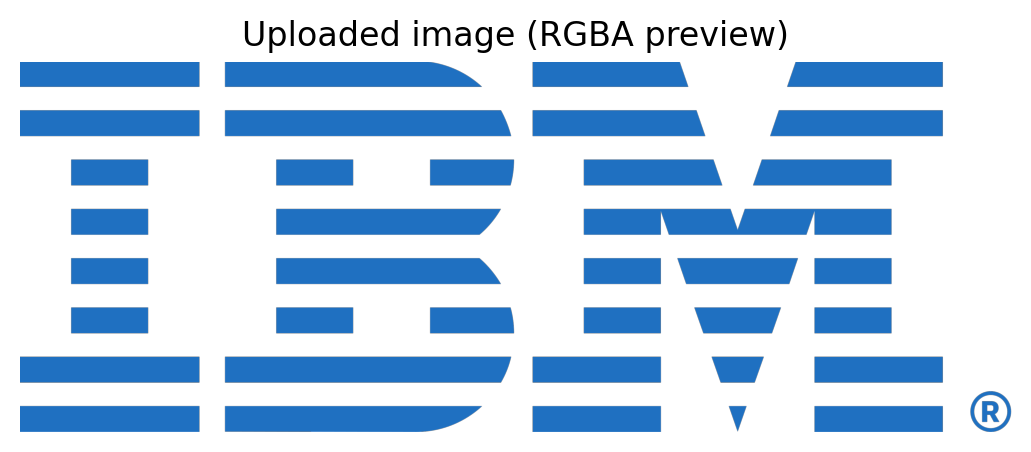

In [3]:
def upload_one_file() -> Tuple[str, bytes]:
    """Prompt user to upload exactly one file in Colab."""
    from google.colab import files  # pylint: disable=import-error

    uploaded: Dict[str, bytes] = files.upload()
    if not uploaded:
        raise RuntimeError("No file uploaded. Please upload an SVG or PNG.")
    if len(uploaded) != 1:
        names = list(uploaded.keys())
        raise RuntimeError(f"Please upload exactly one file, not {len(names)}: {names}")
    name, content = next(iter(uploaded.items()))
    return name, content


def load_rgba_image(name: str, content: bytes, config: Config3D) -> Image.Image:
    """Load an SVG/PNG/JPG into an RGBA image.

    Args:
      name: Filename.
      content: Raw file bytes.
      config: CONFIG controls.

    Returns:
      PIL Image in RGBA mode.
    """
    suffix = Path(name).suffix.lower()

    if suffix == ".svg":
        png_bytes = cairosvg.svg2png(bytestring=content, output_width=config.raster_px_width)
        return Image.open(io.BytesIO(png_bytes)).convert("RGBA")

    if suffix in {".png", ".jpg", ".jpeg"}:
        return Image.open(io.BytesIO(content)).convert("RGBA")

    raise ValueError(f"Unsupported file type: {suffix}. Upload .svg or .png.")


uploaded_name, uploaded_bytes = upload_one_file()
img_rgba = load_rgba_image(uploaded_name, uploaded_bytes, CONFIG)

print(f"Loaded: {uploaded_name}")
print(f"Pixel size: {img_rgba.size}")

plt.figure()
plt.title("Uploaded image (RGBA preview)")
plt.imshow(img_rgba)
plt.axis("off")
plt.show()


Contours extracted: 41
Solid polygons (pixel space): 39


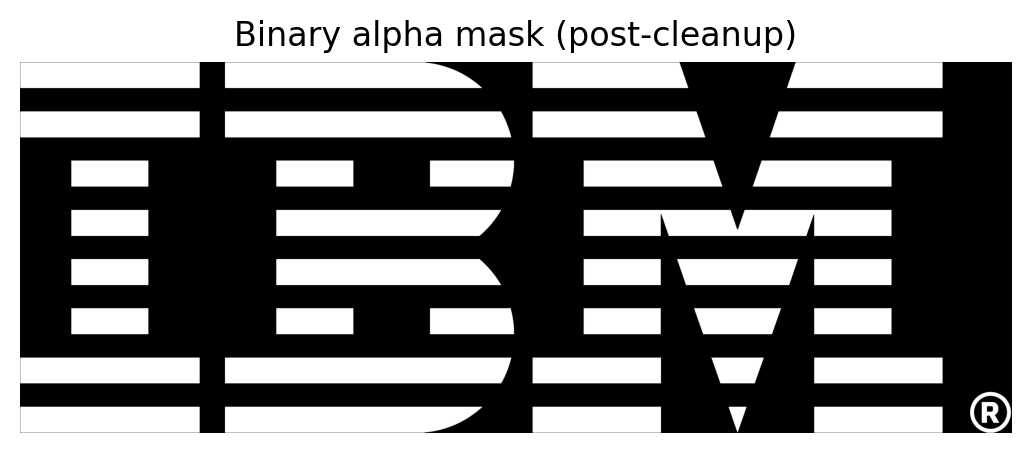

In [4]:
def _flatten_to_polygons(geom: Polygon | MultiPolygon) -> List[Polygon]:
    """Flatten shapely Polygon/MultiPolygon to a list of Polygons."""
    if isinstance(geom, Polygon):
        return [geom]
    return [g for g in geom.geoms if isinstance(g, Polygon)]


def rgba_to_mask(img: Image.Image, config: Config3D) -> np.ndarray:
    """Convert RGBA image to a cleaned binary mask from alpha channel."""
    arr = np.asarray(img)
    alpha = arr[:, :, 3]
    mask = alpha > config.alpha_threshold

    if config.close_radius_px > 0:
        mask = morphology.binary_closing(mask, morphology.disk(config.close_radius_px))

    if config.remove_small_objects_min_px > 0:
        mask = morphology.remove_small_objects(mask, min_size=config.remove_small_objects_min_px)

    # Pad to stabilize contour extraction
    return np.pad(mask, pad_width=1, mode="constant", constant_values=False)


def contours_to_polygons(mask: np.ndarray) -> List[Polygon]:
    """Extract polygons from binary mask using marching squares contours."""
    contours = measure.find_contours(mask.astype(np.float32), level=0.5)
    height, _ = mask.shape

    polys: List[Polygon] = []
    for c in contours:
        # c is (row, col). Convert to (x, y) with y increasing upward.
        x = c[:, 1]
        y = (height - 1) - c[:, 0]
        coords = np.column_stack([x, y])

        poly = Polygon(coords)
        if not poly.is_valid:
            poly = poly.buffer(0)

        for p in _flatten_to_polygons(poly):
            if p.area > 0:
                polys.append(p)

    return polys


def build_solids_with_holes(contours: Sequence[Polygon]) -> List[Polygon]:
    """Interpret nested contours as solids with holes by even/odd depth nesting."""
    n = len(contours)
    if n == 0:
        return []

    bounds = [p.bounds for p in contours]
    areas = [p.area for p in contours]

    def bbox_contains(bo: Tuple[float, float, float, float],
                      bi: Tuple[float, float, float, float]) -> bool:
        return (bo[0] <= bi[0] and bo[1] <= bi[1] and bo[2] >= bi[2] and bo[3] >= bi[3])

    parent = [-1] * n
    for i in range(n):
        best = -1
        best_area = float("inf")
        for j in range(n):
            if areas[j] <= areas[i]:
                continue
            if not bbox_contains(bounds[j], bounds[i]):
                continue
            if contours[j].contains(contours[i]) and areas[j] < best_area:
                best = j
                best_area = areas[j]
        parent[i] = best

    children: List[List[int]] = [[] for _ in range(n)]
    for i, p in enumerate(parent):
        if p != -1:
            children[p].append(i)

    depth = [0] * n
    for i in range(n):
        d = 0
        cur = i
        while parent[cur] != -1:
            cur = parent[cur]
            d += 1
        depth[i] = d

    solids: List[Polygon] = []
    for i in range(n):
        if depth[i] % 2 != 0:
            continue  # this contour is a hole

        holes = []
        for ch in children[i]:
            if depth[ch] == depth[i] + 1:
                holes.append(list(contours[ch].exterior.coords))

        solid = Polygon(contours[i].exterior.coords, holes=holes)
        if not solid.is_valid:
            solid = solid.buffer(0)

        solids.extend(_flatten_to_polygons(solid))

    return solids


mask = rgba_to_mask(img_rgba, CONFIG)
contours = contours_to_polygons(mask)
solids_px = build_solids_with_holes(contours)

print(f"Contours extracted: {len(contours)}")
print(f"Solid polygons (pixel space): {len(solids_px)}")

plt.figure()
plt.title("Binary alpha mask (post-cleanup)")
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()


Final bounds (mm): (0.0, 0.0, 1.0, 0.373530147610708)
Final width  (mm): 1.0
Final height (mm): 0.373530147610708
Polygon count: 39


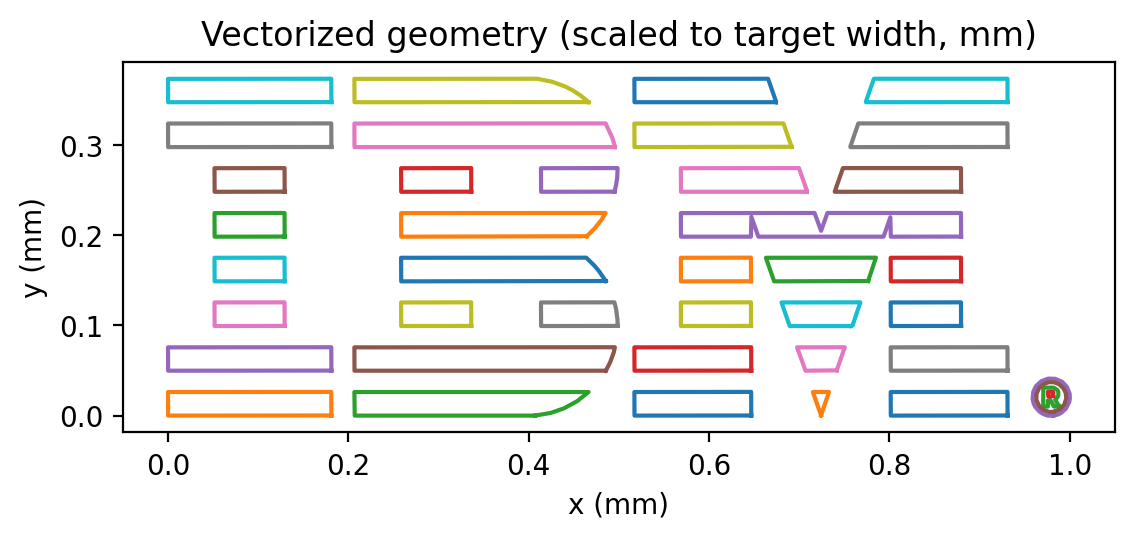

In [5]:
def scale_polys_to_width_mm(polys_px: Sequence[Polygon], target_width_mm: float) -> List[Polygon]:
    """Scale polygons so overall x-span becomes target_width_mm, and translate to x>=0,y>=0."""
    if not polys_px:
        return []

    merged = unary_union(list(polys_px))
    merged_polys = _flatten_to_polygons(merged)

    minx, miny, maxx, _ = merged.bounds
    width_px = maxx - minx
    if width_px <= 0:
        raise ValueError("Degenerate width in extracted geometry.")

    s = target_width_mm / width_px

    out: List[Polygon] = []
    for p in merged_polys:
        p2 = shp_translate(p, xoff=-minx, yoff=-miny)
        p3 = shp_scale(p2, xfact=s, yfact=s, origin=(0.0, 0.0))
        out.append(p3)
    return out


def simplify_polys_mm(polys_mm: Sequence[Polygon], config: Config3D) -> List[Polygon]:
    """Simplify polygons in mm while preserving topology, and filter tiny artifacts."""
    out: List[Polygon] = []
    for p in polys_mm:
        q = p.simplify(config.simplify_tolerance_mm, preserve_topology=True)
        for r in _flatten_to_polygons(q):
            if r.area >= config.min_polygon_area_mm2:
                out.append(r)
    return out


def plot_polys_mm(polys: Sequence[Polygon], title: str) -> None:
    """Plot polygons in mm coordinate space."""
    plt.figure()
    plt.title(title)
    for p in polys:
        ext = np.asarray(p.exterior.coords)
        plt.plot(ext[:, 0], ext[:, 1])
        for hole in p.interiors:
            h = np.asarray(hole.coords)
            plt.plot(h[:, 0], h[:, 1])
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.show()


solids_mm = simplify_polys_mm(scale_polys_to_width_mm(solids_px, CONFIG.target_width_mm), CONFIG)
merged_mm = unary_union(list(solids_mm)) if solids_mm else None

if merged_mm is None:
    raise RuntimeError("No polygons survived processing. Adjust alpha_threshold or cleanup knobs.")

minx, miny, maxx, maxy = merged_mm.bounds
print(f"Final bounds (mm): {(minx, miny, maxx, maxy)}")
print(f"Final width  (mm): {maxx - minx}")
print(f"Final height (mm): {maxy - miny}")
print(f"Polygon count: {len(solids_mm)}")

plot_polys_mm(solids_mm, "Vectorized geometry (scaled to target width, mm)")


In [6]:
def _signed_area(coords_xy: np.ndarray) -> float:
    """Signed area; positive implies counterclockwise."""
    x = coords_xy[:, 0]
    y = coords_xy[:, 1]
    return 0.5 * float(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))


def _ensure_orientation(coords_xy: np.ndarray, clockwise: bool) -> np.ndarray:
    """Ensure ring orientation by reversing point order if needed."""
    area = _signed_area(coords_xy)
    is_ccw = area > 0.0
    if clockwise and is_ccw:
        return coords_xy[::-1].copy()
    if (not clockwise) and (not is_ccw):
        return coords_xy[::-1].copy()
    return coords_xy


def _decimate(coords_xy: np.ndarray, max_points: int) -> np.ndarray:
    """Downsample coordinates to at most max_points points."""
    if coords_xy.shape[0] <= max_points:
        return coords_xy
    idx = np.linspace(0, coords_xy.shape[0] - 1, max_points, dtype=int)
    return coords_xy[idx]


def derive_3d_mesh_knobs(config: Config3D) -> Tuple[float, float, float, float]:
    """Derive mesh sizing defaults suited for thin extrusion with face refinement.

    Returns:
      (lc_min, lc_max, dist_min, dist_max) in millimeters.
    """
    w = config.target_width_mm
    t = config.extrude_thickness_mm

    # For a 1 mm-wide design with 0.01 mm thickness:
    # - lc_min defaults to ~0.002 mm (2 µm), which is “reasonably dense” near faces.
    # - lc_max defaults to ~0.006 mm (6 µm) in interior.
    lc_min = config.lc_min_mm if config.lc_min_mm is not None else min(w / 500.0, t / 5.0)
    lc_max = config.lc_max_mm if config.lc_max_mm is not None else 3.0 * lc_min

    # Transition distances: dist_max must be <= thickness/2 to allow true interior coarsening.
    dist_min = config.dist_min_mm if config.dist_min_mm is not None else 0.5 * lc_min
    dist_max_default = min(0.4 * t, 0.05 * w, 5.0 * lc_min)  # typically 0.004 mm for t=0.01
    dist_max = config.dist_max_mm if config.dist_max_mm is not None else dist_max_default

    # Safety clamp: ensure dist_max is not larger than half thickness.
    dist_max = min(dist_max, 0.5 * t)

    return lc_min, lc_max, dist_min, dist_max


def polys_to_geo_3d(polys_mm: Sequence[Polygon], config: Config3D, out_path: Path) -> None:
    """Write a 3D extruded Gmsh .geo with face-refined sizing."""
    if not polys_mm:
        raise RuntimeError("No polygons to write.")

    lc_min, lc_max, dist_min, dist_max = derive_3d_mesh_knobs(config)

    lines: List[str] = []
    lines.append("// SVG/PNG silhouette -> 3D extruded Gmsh .geo")
    lines.append("// Convention: geometry coordinates are interpreted as millimeters (mm).")
    if config.use_opencascade_factory:
        lines.append('SetFactory("OpenCASCADE");')
    lines.append("")
    lines.append(f"lcMin = {lc_min:.17g};")
    lines.append(f"lcMax = {lc_max:.17g};")
    lines.append(f"distMin = {dist_min:.17g};")
    lines.append(f"distMax = {dist_max:.17g};")
    lines.append(f"distanceSampling = {int(config.distance_sampling)};")
    lines.append(f"thickness = {config.extrude_thickness_mm:.17g};")
    lines.append("")

    pid = 1
    lid = 1
    clid = 1
    sid = 1
    surface_ids: List[int] = []

    def emit_ring(coords_xy: np.ndarray, clockwise: bool) -> int:
        """Emit one ring as Points/Lines/Curve Loop, returning loop id."""
        nonlocal pid, lid, clid

        coords_xy = coords_xy.astype(np.float64)
        coords_xy = _decimate(coords_xy, config.max_points_per_ring)

        # Remove last point if it repeats the first (common in shapely rings)
        if coords_xy.shape[0] >= 2 and np.allclose(coords_xy[0], coords_xy[-1]):
            coords_xy = coords_xy[:-1]

        coords_xy = _ensure_orientation(coords_xy, clockwise=clockwise)
        if coords_xy.shape[0] < 3:
            raise ValueError("Ring has fewer than 3 vertices after processing.")

        point_ids: List[int] = []
        for x, y in coords_xy:
            lines.append(f"Point({pid}) = {{{x:.17g}, {y:.17g}, 0, lcMin}};")
            point_ids.append(pid)
            pid += 1

        line_ids: List[int] = []
        for i in range(len(point_ids)):
            a = point_ids[i]
            b = point_ids[(i + 1) % len(point_ids)]
            lines.append(f"Line({lid}) = {{{a}, {b}}};")
            line_ids.append(lid)
            lid += 1

        lines.append(f"Curve Loop({clid}) = {{{', '.join(str(x) for x in line_ids)}}};")
        loop_id = clid
        clid += 1
        return loop_id

    # 2D surfaces
    for poly in polys_mm:
        outer = emit_ring(np.asarray(poly.exterior.coords), clockwise=False)
        holes = [emit_ring(np.asarray(h.coords), clockwise=True) for h in poly.interiors]
        loops = [outer] + holes
        lines.append(f"Plane Surface({sid}) = {{{', '.join(str(x) for x in loops)}}};")
        surface_ids.append(sid)
        sid += 1
        lines.append("")

    lines.append(f"allSurfaces[] = {{{', '.join(str(x) for x in surface_ids)}}};")
    lines.append("")

    # Extrude each surface into a volume
    lines.append("vols[] = {};")
    lines.append("For i In {0:#allSurfaces[]-1}")
    lines.append("  s = allSurfaces[i];")
    lines.append("  out[] = Extrude {0, 0, thickness} { Surface{s}; };")
    lines.append("  vols[] += out[1]; // out[1] is the new Volume")
    lines.append("EndFor")
    lines.append("")

    # Boundary surfaces of the volume collection
    lines.append("bndSurfaces[] = Boundary{ Volume{vols[]}; };")
    lines.append("")
    lines.append('Physical Volume("design") = {vols[]};')
    lines.append('Physical Surface("outer_faces") = {bndSurfaces[]};')
    lines.append("")

    # Mesh sizing: denser near outer faces, coarser interior
    lines.append("// Face-refined / interior-coarse background mesh field")
    lines.append("Field[1] = Distance;")
    lines.append("Field[1].SurfacesList = {bndSurfaces[]};")
    lines.append("Field[1].Sampling = distanceSampling;")
    lines.append("Field[2] = Threshold;")
    lines.append("Field[2].InField = 1;")
    lines.append("Field[2].SizeMin = lcMin;")
    lines.append("Field[2].SizeMax = lcMax;")
    lines.append("Field[2].DistMin = distMin;")
    lines.append("Field[2].DistMax = distMax;")
    lines.append("Background Field = 2;")
    lines.append("")

    # Let the field dominate
    lines.append("Mesh.MeshSizeExtendFromBoundary = 0;")
    lines.append("Mesh.MeshSizeFromPoints = 0;")
    lines.append("Mesh.MeshSizeFromCurvature = 0;")
    lines.append("Mesh.MeshSizeMin = lcMin;")
    lines.append("Mesh.MeshSizeMax = lcMax;")
    lines.append("")
    lines.append("// Generate a 3D mesh when opened/run in Gmsh")
    lines.append("Mesh 3;")

    out_path.write_text("\n".join(lines), encoding="utf-8")


stem = Path(uploaded_name).stem
out_geo = Path(f"{stem}_3d_{CONFIG.target_width_mm:g}mm_w_{CONFIG.extrude_thickness_mm:g}mm_t.geo")

polys_to_geo_3d(solids_mm, CONFIG, out_geo)

print(f"Wrote: {out_geo.resolve()}")

geo_text = out_geo.read_text(encoding="utf-8")
print("\n===== BEGIN GEO FILE =====\n")
print(geo_text)
print("\n===== END GEO FILE =====\n")


Wrote: /content/IBM_logo_3d_1mm_w_0.01mm_t.geo

===== BEGIN GEO FILE =====

// SVG/PNG silhouette -> 3D extruded Gmsh .geo
// Convention: geometry coordinates are interpreted as millimeters (mm).
SetFactory("OpenCASCADE");

lcMin = 0.002;
lcMax = 0.0060000000000000001;
distMin = 0.001;
distMax = 0.0040000000000000001;
distanceSampling = 200;
thickness = 0.01;

Point(1) = {0.64660995746810102, 0.026269702276707531, 0, lcMin};
Point(2) = {0.51713785339004248, 0.026144608456342255, 0, lcMin};
Point(3) = {0.51726294721040778, 0, 0, lcMin};
Point(4) = {0.64673505128846631, 0.00012509382036527395, 0, lcMin};
Line(1) = {1, 2};
Line(2) = {2, 3};
Line(3) = {3, 4};
Line(4) = {4, 1};
Curve Loop(1) = {1, 2, 3, 4};
Plane Surface(1) = {1};

Point(5) = {0.18101075806855141, 0.026269702276707531, 0, lcMin};
Point(6) = {0, 0.026144608456342255, 0, lcMin};
Point(7) = {0.00012509382036527395, 0, 0, lcMin};
Point(8) = {0.18113585188891668, 0.00012509382036527395, 0, lcMin};
Line(5) = {5, 6};
Line(6) = {6,

In [7]:
from google.colab import files  # pylint: disable=import-error

files.download(str(out_geo))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>